In [1]:
#load libraries
import numpy as np
import math
from math import sqrt
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from scipy.stats import norm, lognorm
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance, Voronoi, voronoi_plot_2d, ConvexHull, Delaunay
from collections import defaultdict
import itertools
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random
import sys
from itertools import combinations 
import time
from scipy import stats
from sklearn.svm import SVC
import sobol_seq
import os,glob

#plotting style
%matplotlib inline
sns.set()
sns.set_style('white')

In [3]:
def js_divergence_scipy(hist1,hist2):
    return (distance.jensenshannon(hist1, hist2, base=2))**2

def nearest_neighbors(values, all_values, nbr_neighbors=1):
    nn = NearestNeighbors(nbr_neighbors, metric='euclidean', algorithm='kd_tree').fit(all_values)
    dists, idxs = nn.kneighbors(values)
    return idxs

def golden(n,d=2):
    g = 1.324717572447460256 
    alpha = np.zeros(d) 
    for j in range(d): 
        alpha[j] = pow(1/g,j+1) %1 
    z = np.zeros((n, d)) 
    seed=0.5
    for i in range(n): 
        z[i] = (seed + alpha*(i+1)) %1 
    return z

def svc_decision_boundary_coords(model,x_lim=(0,110),y_lim=(0,110),numb=200):
    """Return the decision boundary coordinates for a 2D SVC"""    
    # create grid to evaluate model
    x = np.linspace(x_lim[0], x_lim[1], numb)
    y = np.linspace(y_lim[0], y_lim[1], numb)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    
    boundary=plt.contour(X, Y, P, colors='k',
               levels=[0], alpha=0.5,
               linestyles=['-'])
    plt.close()
    
    p = boundary.collections[0].get_paths()[0]
    v = p.vertices
    
    boundary_coords = v[:,[0,1]]
    
    return boundary_coords

def svc_decision_boundary_length_and_coords(model,x_lim=(0,10),y_lim=(0,10),numb=300):
    """Return the decision boundary coordinates for a 2D SVC"""

#     x_lim=(2,8)
#     y_lim=(0,4)
    
    # create grid to evaluate model
    x = np.linspace(x_lim[0], x_lim[1], numb)
    y = np.linspace(y_lim[0], y_lim[1], numb)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    
    boundary=plt.contour(X, Y, P, colors='k',
               levels=[0], alpha=0.5,
               linestyles=['-'])
    plt.close()
    
    p = boundary.collections[0].get_paths()[0]
    v = p.vertices
    boundary_coords = v[:,[0,1]]
    
    x = np.ravel(boundary_coords[:,0])
    y = np.ravel(boundary_coords[:,1])

    dist_array = (x[:-1]-x[1:])**2 + (y[:-1]-y[1:])**2

    return np.sum(np.sqrt(dist_array)), boundary_coords





def hexagonal_sym_ops():
    #everything to calculate disorientations
    a=sqrt(0.75)

    #12 hexagonal close-packed crystal symmetry operators
    op25=np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
    op26=np.array([[-0.5, a, 0],[-a, -0.5, 0],[0, 0, 1]])
    op27=np.array([[-0.5, -a, 0],[a, -0.5, 0],[0, 0, 1]])
    op28=np.array([[0.5, a, 0],[-a, 0.5, 0],[0, 0, 1]])
    op2=np.array([[-1, 0, 0],[0, -1, 0],[0, 0, 1]])
    op30=np.array([[0.5, -a, 0],[a, 0.5, 0],[0, 0, 1]])
    op31=np.array([[-0.5, -a, 0],[-a, 0.5, 0],[0, 0, -1]])
    op32=np.array([[1, 0, 0],[0, -1, 0],[0, 0, -1]])
    op33=np.array([[-0.5, a, 0],[a, 0.5, 0],[0, 0, -1]])
    op34=np.array([[0.5, a, 0],[a, -0.5, 0],[0, 0, -1]])
    op35=np.array([[-1, 0, 0],[0, 1, 0],[0, 0, -1]])
    op36=np.array([[0.5, -a, 0],[-a, -0.5, 0],[0, 0, -1]])

    op25,op26,op27,op28,op2,op30,op31,op32,op33,op34,op35,op36

    #list of hexagonal sym ops
    return [op25,op26,op27,op28,op2,op30,op31,op32,op33,op34,op35,op36]

#input is an array in radians as follows euler=[angle_one,angle_two,angle_three]
def misorientation(euler_one, euler_two,sym_op):
    #orientation matrices
    g_one=np.array([[((math.cos(euler_one[0]))*(math.cos(euler_one[2]))-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[0]))*(math.cos(euler_one[2]))+(math.cos(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[2]))*(math.sin(euler_one[1])))],
                [(-(math.cos(euler_one[0]))*(math.sin(euler_one[2]))-(math.sin(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),(-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))+(math.cos(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),((math.cos(euler_one[2]))*(math.sin(euler_one[1])))],
                [((math.sin(euler_one[0]))*(math.sin(euler_one[1]))),(-(math.cos(euler_one[0]))*(math.sin(euler_one[1]))),(math.cos(euler_one[1]))]        
                ])
   
    #euler_two
    g_two=np.array([[((math.cos(euler_two[0]))*(math.cos(euler_two[2]))-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[0]))*(math.cos(euler_two[2]))+(math.cos(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[2]))*(math.sin(euler_two[1])))],
                [(-(math.cos(euler_two[0]))*(math.sin(euler_two[2]))-(math.sin(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),(-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))+(math.cos(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),((math.cos(euler_two[2]))*(math.sin(euler_two[1])))],
                [((math.sin(euler_two[0]))*(math.sin(euler_two[1]))),(-(math.cos(euler_two[0]))*(math.sin(euler_two[1]))),(math.cos(euler_two[1]))]        
                ])
    
#     #misorientation matrix
    delta_g=np.matmul(g_one,np.linalg.inv(g_two))
    
    #disorientation matrix
    #problem here!!!
#     delta_gd=np.matmul((np.matmul(g_two,sym_op)),(np.matmul(np.linalg.inv(sym_op),np.linalg.inv(g_one))))
    #formula from powerpoint
    delta_gd=np.matmul(sym_op,delta_g)
    
#     #angle in radians
#     theta=np.arccos((np.trace(delta_gd)-1)/2)
    
    #misorientation angle
    try:
        theta=np.arccos((np.trace(delta_gd)-1)/2)
    #error handling for rounding errors outside of domain
    except:
        if (((np.trace(delta_gd)-1)/2)>1):
            theta=0
        else:
            theta=180

    return math.degrees(theta)


#find the minimum misorientation using sym ops
def disorientation(euler_one, euler_two):
    global hex_sym_ops
    
    misorientation_list=[]
    for sym_op in hex_sym_ops:
        misorientation_list.append(misorientation(euler_one, euler_two,sym_op))
    
    #disorientation is the minimum of the 24 misorientations - for cubic symmetry 
    return min(misorientation_list)
#     return misorientation_list




def adj_dict(data):
    coords=data[:,[3,4]]
    tri=Delaunay(coords)
    neigh=defaultdict(set)
    for p in tri.simplices:
        for i,j in itertools.combinations(p,2):
            neigh[i].add(j)
            neigh[j].add(i)
    return neigh





#create a grain adj dict
def label_rdb_and_create_grainadj(array,misorient_angle=15):    
    #create point adj dict
    vor_adj=adj_dict(array)
    
    # create grain adj dict
    grain_neigh=defaultdict(set)
    
    #create grain adj dict
    for key in vor_adj:
        euler_one=[array[key][0],array[key][1],array[key][2]]
        for value in vor_adj[key]:
            euler_two=[array[value][0],array[value][1],array[value][2]]
            vor_disorient=disorientation(euler_one,euler_two)
            if vor_disorient > misorient_angle:    
                #add to adj grain dict
                grain_ID_one=array[key,5]
                grain_ID_two=array[value,5]
                grain_ID_one=int(grain_ID_one)
                grain_ID_two=int(grain_ID_two)
                grain_neigh[int(grain_ID_one)].add(grain_ID_two)
                grain_neigh[int(grain_ID_two)].add(grain_ID_one)
                
                #relabel array
                #label edges
                array[key,6]=1
                array[value,6]=1
                
                #add adj grains to a point
                array[key,8]=array[value,5]
                array[value,8]=array[key,5]
                
    return grain_neigh





#improves previous method by including surrounding information and preventing errors when there are few support vectors
def SVM_infill(array):
    coords=raw_data[:,3:5] #need to change back to raw data, may change to improve runtime
    in_polygon=np.zeros((len(coords),4)) #expand to support orientations
    polygon_coords=np.concatenate((coords,in_polygon),axis=1) #.reshape(-1,1)
    
    #create grain adj dict
    new_grain_adj_dict=grain_adj_dict(array)
    #find SVM grain boundary using surrounding grains and expand to find support vectors
    for grain_ID in new_grain_adj_dict:
#     for grain_ID in [2]:
        #get the neighboring grain IDs
        IDs=list(new_grain_adj_dict[grain_ID])
        #append current ID
        IDs.append(grain_ID)

        #slice data for SVM
        X=array[(np.isin(array[:,5],IDs)),3:5]
        Y=array[(np.isin(array[:,5],IDs)),5:6]
        #modify Y to be two clusters
        Y[np.where(Y!=grain_ID)]=-1
        Y[np.where(Y==grain_ID)]=-2
        Y=np.squeeze(Y)
        
        #create model
        model = SVC(kernel='rbf', C=1e10, gamma=1)
        model.fit(X, Y)
        #plot model
#         plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='autumn')
#         plot_svc_decision_function(model);

        #call model
        polygon=svc_decision_boundary_coords(model)
        #plot model
#         plt.scatter(polygon[:,0],polygon[:,1], c='green')
        
        #create polygon of model boundary
        polygon = np.vstack((polygon,polygon[0])) #close polygon
        line = geometry.LineString(polygon)
        polygon = geometry.Polygon(line)
        
        #test if single points are in the polygon
        index=0
        for coord in coords:
            point = geometry.Point(coord)
            if polygon.contains(point):
                #assign grain ID
                polygon_coords[index,2]=grain_ID
                #assign angles to nearest neighbor
                polygon_coords[index,3:6]=array[nearest_neighbors(coord.reshape(1,-1),array[:,3:5]),0:3]
            index+=1

        #plot results for a grain
#         poly_coords=polygon_coords[np.where(polygon_coords[:,2]==grain_ID)]
#         plt.scatter(poly_coords[:,0],poly_coords[:,1], c='blue')
       
   
    #assign gaps (zeros) to nearest point
    index=0
    for row in polygon_coords:
        if row[2]==0:
            polygon_coords[index,2]=raw_data[nearest_neighbors(polygon_coords[index,0:2].reshape(1,-1),array[:,3:5]),5]
        index+=1
#     return polygon_coords   
                                  
    #change grain IDs and angles to new ones
    infilled_raw_data=np.copy(raw_data)
    infilled_raw_data[:,0:3]=polygon_coords[:,3:6]
    infilled_raw_data[:,5]=polygon_coords[:,2]
                                  
    #use as input to grain_misorient calculation
    return infilled_raw_data





def grain_misorients(array, hist_bool=True, return_p=False):
    global p
    
    #add boundaries - 6
    boundaries=np.zeros((len(array),1))
    rdb=np.concatenate((array,boundaries.reshape(-1,1)),axis=1)

    #add neighbors for rec_neighbors - 7
    neighbors=np.zeros((len(array),1))
    rdb=np.concatenate((rdb,neighbors.reshape(-1,1)),axis=1)

    #add neighbors for points/grains - 8
    rdb=np.concatenate((rdb,neighbors.reshape(-1,1)),axis=1)

    #add row_IDs for adj dict - 
    row_IDs=np.arange(1,len(array)+1)
    rdb=np.concatenate((rdb,row_IDs.reshape(-1,1)),axis=1)

    #add column for len calculation - 10
    length=np.zeros((len(array),1))
    rdb=np.concatenate((rdb,length.reshape(-1,1)),axis=1)
    
    #create point and grain adj dicts
    point_adj=adj_dict(rdb)
    grain_neigh=label_rdb_and_create_grainadj(rdb)
    
    #initialize misorientations and lengths/weights for histogram
    avg_boundary_disorients = np.zeros((5000,1))
    boundary_lens = np.zeros((5000,1))
    
    #calculate grain misorients and lengths
    #**************************************
    
    index=0
    # for each grain
    for grain_ID_1_ in np.unique(rdb[:,5]):
        #get the points and edges of the grain
        rdb_slice_1_=rdb[np.where(rdb[:,5]==grain_ID_1_)]
        rdb_edge_1_=rdb_slice_1_[np.where(rdb_slice_1_[:,6]==1)]

        #for each neighboring grain
        for grain_ID_2_ in grain_neigh[grain_ID_1_]:
            #don't compare the same grain
            if int(grain_ID_1_) != int(grain_ID_2_):
                #get the boundary points of grain 1 with grain 2
                rdb_boundary_1_=rdb_edge_1_[np.where(rdb_edge_1_[:,8]==grain_ID_2_)]

                #slice grain 2
                rdb_slice_2_=rdb[np.where(rdb[:,5]==grain_ID_2_)]
                rdb_edge_2_=rdb_slice_2_[np.where(rdb_slice_2_[:,6]==1)]
                rdb_boundary_2_=rdb_edge_2_[np.where(rdb_edge_2_[:,8]==grain_ID_1_)]

                #append boundaries together
                rdb_boundary_=np.append(rdb_boundary_1_, rdb_boundary_2_, axis=0)

                #slice boundary
                X=rdb_boundary_[:,3:5]
                y=rdb_boundary_[:,5]

                #if no points, bad
                if len(X) < 2:
                    break

                #don't sample the same grain
                if len(np.unique(y)) < 2:
                    break

                #create model
                model = SVC(kernel='rbf', C=1e10, gamma=1)
                model.fit(X, y)
                #return length and coords of boundary
                boundary_len_, boundary_coords_ = svc_decision_boundary_length_and_coords(model,x_lim=(min(X[:,0]),max(X[:,0])),y_lim=(min(X[:,1]),max(X[:,1])),numb=30)

                # append boundary length
                boundary_lens[index]=boundary_len_

                #create two new columns to hold nearest neighbor and a third column for misorientation
                new_columns=np.zeros((len(boundary_coords_),3))
                boundary_coords_=np.concatenate((boundary_coords_,new_columns),axis=1)

                #row ID of nearest coord in bound1
                row_1_ID=0
                #for each SVM boundary point
                for row_1 in boundary_coords_:
                    coords_1=row_1[0:2]
                    distances_and_row_IDs=defaultdict(set)
                    #for each point in the first grain boundary
                    for row_2 in rdb_boundary_1_: #!!!!!!!!!!!!!!!!!!!!!!!!!!! Instead of boundary, use sampled coords, add input for actual data, run smvinfill in parallel, then combine...time to read code.....
                        coords_2=row_2[3:5]
                        #calculate distance
                        dist=round(distance.euclidean(coords_1,coords_2),3)
                        #add row ID of grain boundary point for misorient
                        distances_and_row_IDs[dist].add(row_2[6])
                    #find minimum distance
                    min_dist = min(distances_and_row_IDs.keys())
                    #add row ID of min dist
                    bound_1_ID=list(distances_and_row_IDs[min_dist])
                    boundary_coords_[row_1_ID,2]=bound_1_ID[0]
                    row_1_ID+=1       

                #bound2 neighbor of each coord
                row_1_ID=0
                #for each SVM boundary point
                for row_1 in boundary_coords_:
                    coords_1=row_1[0:2]
                    distances_and_row_IDs=defaultdict(set)
                    #for each point in the first grain boundary
                    for row_2 in rdb_boundary_2_:
                        coords_2=row_2[3:5]
                        #calculate distance
                        dist=round(distance.euclidean(coords_1,coords_2),3)
                        #add row ID of grain boundary point for misorient
                        distances_and_row_IDs[dist].add(row_2[6])
                    #find minimum distance
                    min_dist = min(distances_and_row_IDs.keys())
                    #add row ID of min dist
                    bound_1_ID=list(distances_and_row_IDs[min_dist])
                    boundary_coords_[row_1_ID,3]=bound_1_ID[0]
                    row_1_ID+=1 

                #calculate each misorientation
                row_ID=0
                for row in boundary_coords_:
                    key=int(boundary_coords_[row_ID,2])-1
                    euler_one_=[rdb[key][0],rdb[key][1],rdb[key][2]]
                    value=int(boundary_coords_[row_ID,3])-1
                    euler_two_=[rdb[value][0],rdb[value][1],rdb[value][2]]
                    boundary_coords_[row_ID,4]=disorientation(euler_one_,euler_two_)
                    row_ID+=1

                #find the total average and append
                avg_boundary_disorients[index]=np.mean(boundary_coords_[:,4])

                index+=1
                
    #**************************************
    
    #discard misorientations below 15 degrees
    keep=np.where(avg_boundary_disorients>15)
    avg_boundary_disorients_over15 = avg_boundary_disorients[keep]
    boundary_lens_over15 = boundary_lens[keep]
    abd=avg_boundary_disorients_over15
    bl=boundary_lens_over15
    count=np.multiply(abd,bl)
    return abd, bl, count
    if return_p==True:
        plt.hist(abd, bins=np.arange(15,100,2), range=(15,100), density=True)
        q, q_bin_edges = np.histogram(abd, bins=np.arange(15,100,2), range=(15,100), density=True)
        q = np.append(q, 0)
        return q
    
    #create histogram
    if hist_bool==True:
        plt.hist(abd, bins=np.arange(15,100,2), range=(15,100), density=True)
        q, q_bin_edges = np.histogram(abd, bins=np.arange(15,100,2), range=(15,100), density=True)
        q = np.append(q, 0)
        return js_divergence_scipy(p,q)
    
    else:
        sample_mean=np.mean(abd)
        sample_var=np.var(abd)
        return sample_mean, sample_var  
 
    
    

    
def sample(size,method,hist=True):   
    if method == 'random':
        #choose random points
        sliced_raw_data = raw_data[np.random.choice(raw_data.shape[0], size, replace=False), :]
    
    if method == 'square':
        phi = (np.sqrt(5)+1)/2
        ratio = np.sqrt(3)/2 # cos(60°)
        coords = raw_data[:,3:5]
        N = size
        
        N_X = int(np.sqrt(N))
        N_Y = N // N_X
        xv, yv = np.meshgrid(np.arange(N_X), np.arange(N_Y), sparse=False, indexing='xy')
        square_coords=np.concatenate((xv.reshape(-1,1), yv.reshape(-1,1)), axis=1)
        square_coords[:,0] = square_coords[:,0] * (np.amax(raw_data[:,3]) / np.amax(square_coords[:,0]))
        square_coords[:,1] = square_coords[:,1] * (np.amax(raw_data[:,4]) / np.amax(square_coords[:,1]))
        grid_sample=raw_data[nearest_neighbors(square_coords,coords)]
        sliced_raw_data=grid_sample[:,0]
        
    if method == 'hex':
        phi = (np.sqrt(5)+1)/2
        ratio = np.sqrt(3)/2 # cos(60°)
        coords = raw_data[:,3:5]
        N = size
        
        N_X = int(np.sqrt(N)/ratio)
        N_Y = N // N_X
        xv, yv = np.meshgrid(np.arange(N_X), np.arange(N_Y), sparse=False, indexing='xy')
        xv = xv * ratio
        xv[::2, :] += ratio/2
        hex_coords=np.concatenate((xv.reshape(-1,1), yv.reshape(-1,1)), axis=1)
        hex_coords[:,0] *= (np.amax(raw_data[:,3]) / np.amax(hex_coords[:,0]))
        hex_coords[:,1] *= (np.amax(raw_data[:,4]) / np.amax(hex_coords[:,1]))
        grid_sample=raw_data[nearest_neighbors(hex_coords,coords)]
        sliced_raw_data=grid_sample[:,0]
        
    if method == 'sobol':
        #choose 2D sobol points
        sobol = (sobol_seq.i4_sobol_generate(2, size))
        sobol[:,0]*=np.amax(raw_data[:,3])
        sobol[:,1]*=np.amax(raw_data[:,4])
        sobol_sample=raw_data[nearest_neighbors(sobol,coords)]
        sliced_raw_data=sobol_sample[:,0]
        
    if method == 'gold':
        #choose 2D golden points
        golden_2D = golden(size)
        golden_2D[:,0]*=np.amax(raw_data[:,3])
        golden_2D[:,1]*=np.amax(raw_data[:,4])
        golden_sample=raw_data[nearest_neighbors(golden_2D,coords)]
        sliced_raw_data=golden_sample[:,0]
        
#     if method == 'window':
# #         percent=sqrt(size/len(raw_data))
#         percent=sqrt(size/100000) #filesize
#         window_divergences=[]
#         window_means=[]
#         window_vars=[]
        
#         for raw_data_slice_x in window_slice_list:
#             raw_data_slice=raw_data_slice_x
    
#             row_list=[]
#             for index in range(0,len(raw_data_slice)):
#                 if (raw_data_slice[index,3]<=int((np.amax(raw_data[:,3])*percent))) and (raw_data_slice[index,4]<=int((np.amax(raw_data[:,4])*percent))):
#                     row_list.append(raw_data_slice[index, 0:3])
#                 else:
#                     continue

#             row_tuple=tuple(row_list)
#             sliced_raw_data_slice=np.vstack(row_tuple)
            
#             sliced_coords=sliced_raw_data_slice[:,0:2]
#             sliced_grain_IDs=sliced_raw_data_slice[:,2]
#             if hist==True:
#                 window_divergences.append(grain_areas(sliced_coords,sliced_grain_IDs,percent,window_vol=True,hist_bool=hist))
#                 #return average JS Divergence
#                 return sum(window_divergences)/4
#             else:
#                 temp_mean, temp_var=grain_areas(sliced_coords,sliced_grain_IDs,percent,window_vol=True,hist_bool=hist)
#                 window_means.append(temp_mean)
#                 window_vars.append(temp_var)
#         if hist==True:
#             #return average JS Divergence
#             return sum(window_divergences)/4
#         else:
#             temp_mean_avg=sum(window_means)/4
#             temp_var_avg=sum(window_vars)/4
#             return temp_mean_avg, temp_var_avg
    
    #return JS Divergence
    return grain_misorients(sliced_raw_data, hist_bool=hist)

In [4]:
#load data
raw_data = np.loadtxt('Data Files/EBSD Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(0,1,2,3,4,8))
raw_data_copy=np.copy(raw_data)

# load file, skip header, load angles and coordinates, also grain ID
coords=np.loadtxt('Data Files/EBSD Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(3,4))
grain_IDs=np.loadtxt('Data Files/EBSD Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(8))
grain_IDs_and_edges=np.loadtxt('Data Files/EBSD Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(8,9))
coords_and_grains=np.loadtxt('Data Files/EBSD Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(3,4,8))
coords_and_grains_copy=np.copy(coords_and_grains)

hex_sym_ops=hexagonal_sym_ops()

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in arccos


[0.00558109 0.00897352 0.01400744 0.01367914 0.01411687 0.0165244
 0.01674327 0.0198074  0.01860363 0.01630554 0.01553951 0.01280368
 0.01302254 0.01269424 0.01105275 0.01050558 0.01127161 0.00809805
 0.01116218 0.01061501 0.01149048 0.01181878 0.01313198 0.01170935
 0.01203764 0.01050558 0.01138105 0.01192821 0.01707157 0.01411687
 0.01291311 0.01225651 0.01477347 0.01313198 0.01564894 0.01433574
 0.01488291 0.01291311 0.00284526 0.         0.         0.
 0.        ]


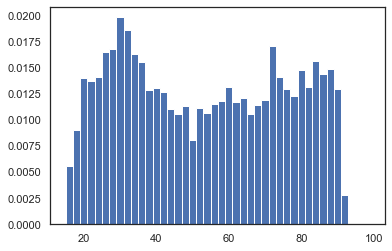

In [35]:
p=grain_misorients(raw_data,return_p=True)
print(p)

In [5]:
#see if weighted histogram produces a flat 
xy_max=12
raw_data_slice=raw_data[np.where((raw_data[:,3]<=xy_max) & (raw_data[:,4]<=xy_max))]
abd, bl, count=grain_misorients(raw_data_slice)

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in arccos


In [6]:
#arbitrarily scale up so they become ints (will be scaled back by norming)
scaled_bl=bl*1000
scaled_bl=scaled_bl.astype(int)

In [7]:
count=[]

for x in np.arange(0,len(abd)):
    weighted_abd=[abd[x].astype(list)]*int(scaled_bl[x])
    count.extend(weighted_abd)

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan]),
 array([15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47,
        49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81,
        83, 85, 87, 89, 91, 93, 95, 97, 99]),
 <BarContainer object of 42 artists>)

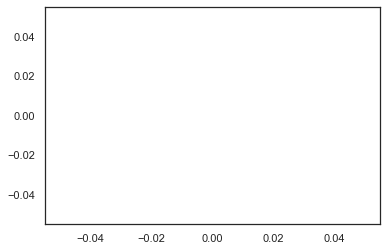

In [8]:
# np.histogram(count, bins=np.arange(15,100,2), range=(15,100), normed=True)
plt.hist(count, bins=np.arange(15,100,2), range=(15,100), density=True)